# V4: evaluation frame work

In [1]:
import matplotlib.pyplot as plt
import torch

In [2]:
def target_function1(x):
    return torch.exp(-x*4)*torch.cos(x*20)
def get_data(fn,N):
    x = torch.rand(N)
    y = fn(x)
    return x,y
def choice(x,y,N): # (num_train,1),(num_train,1),int
    idx = torch.randint(0,x.size(0),(N,))
    return x[idx],y[idx] # (N,1)
def nm(x):
    if 'cpu' in x.device.type:
        return x.detach().numpy()
    else:
        return x.detach().cpu().numpy()

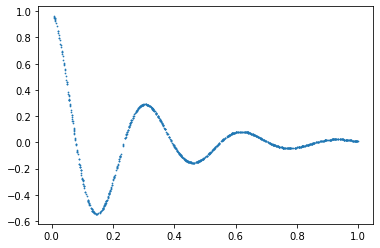

In [3]:
x = torch.rand(1000)
y = target_function1(x)
plt.scatter(nm(x),nm(y),s=0.5)

## two layer res net is best model in 10 sec

In [4]:
import torch.nn as nn
class TwoLayerNetRes(torch.nn.Module):
    def __init__(self, D_in, H, D_out):
        super(TwoLayerNetRes, self).__init__()
        self.linear1 = torch.nn.Linear(D_in, H)
        self.linear2 = torch.nn.Linear(H, H)
        self.linear3 = torch.nn.Linear(H, D_out)
    def forward(self,x):
        h_relu1 = self.linear1(x).clamp(min=0)
        h_relu2 = self.linear2(h_relu1).clamp(min=0)
        y_pred = self.linear3(h_relu2+h_relu1)
        return y_pred

## find best by optuna = Res4layer(600x600)
- try to predict

In [6]:
import time

# make practical model

In [18]:
import pickle

In [10]:
class AbstModel(object):
    def __init__(self,device):
        self.device = device
        self.name = 'abst2_model'
        
    def pred_mean(self,x): # (10000)
        return torch.randn(x.shape[0]).to(self.device) # (10000)
    
    def pred_unce(self,x): # (10000)
        return torch.randn(x.shape[0]).to(self.device) # (10000)
    
    def learn(self,x,y): # x:(itr,1), y:(itr,1)   
        # learn in 10 sec
        pass

def eval_model(model):
    x,y = get_data(target_function1,100000)
    x = x.to(model.device)
    y = y.to(model.device)
    y_pred = model.pred_mean(x)
    return torch.pow(y - y_pred,2).mean()

def make_log(save_name,eva,train_x,train_y,model):
    log = {}
    log['eval'] = eva
    log['train_x'] = nm(train_x)
    log['train_y'] = nm(train_y)
    log['all_x'] = nm(torch.linspace(0, 1, steps=10000))
    log['all_y'] = nm(target_function1(torch.linspace(0, 1, steps=10000)))
    log['all_y_mean'] = nm(model.pred_mean(torch.linspace(0, 1, steps=10000).to(model.device)))
    log['all_y_unce'] = nm(model.pred_unce(torch.linspace(0, 1, steps=10000).to(model.device)))
    with open(save_name,mode='wb') as f:
        pickle.dump(log,f)

def draw(load_name,save_name):
    with open(load_name,mode='rb') as f:
        load_log = pickle.load(f)
    fig, ax = plt.subplots(1, 2, figsize=(13, 5),dpi=100)
    fig.suptitle(load_name)
    ax[0].plot(load_log['eval'])
    ax[0].set_xlabel('Number of data collected')
    ax[0].set_ylabel('MSE over 100k samples')
    ax[1].plot(load_log['all_x'],load_log['all_y_mean'],label='prediction_mean',color='red',lw=1)
    ax[1].fill_between(load_log['all_x'],load_log['all_y_mean']-load_log['all_y_unce'],
                       load_log['all_y_mean']+load_log['all_y_unce'],label='prediction_unce',color='pink',alpha=0.6)
    ax[1].scatter(load_log['train_x'],load_log['train_y'],label='train data',color='blue',s=2,zorder=100)
    ax[1].legend()
    ax[1].set_xlabel('x')
    ax[1].set_ylabel('y')
    plt.savefig(save_name,dpi=100,format = 'png')

## Evaluation Framework

# QRNN
- one model predict all quantiles
- unce was defined by entropy $\log(abcd)$
- center:= learned by L1 original loss
- other quantile is representated by 

In [75]:
MAX_TIME=2
MAX_ITR = 1000000
MIN_WIDTH = 1e-6
class QRNNModel(AbstModel):
    def __init__(self,device,num_head,H=600,b_size=128):
        super().__init__(device)
        self.H = H
        self.device=device
        self.b_size = b_size
        assert num_head%2!=0, 'even number'
        self.quantiles = torch.tensor(
            [i/(num_head+1) for i in range(1,num_head+1)],dtype=torch.float).to(device)
        self.num_head = num_head
        self.name = 'qrnn_of_'+str(num_head)
        self.model = TwoLayerNetRes(1,H,num_head).to(self.device) # (10000,num_head)
        self.optim = torch.optim.Adadelta(self.model.parameters())
        self.center_id = int(num_head/2)
        # make q_head
        width = int((num_head-1)/2)
        self.q_head = torch.zeros((num_head,num_head),dtype=torch.float).to(device)
        self.q_head[self.center_id,:] = 1
        for i in range(0,width):
            self.q_head[i,:i+1] = 1
            self.q_head[num_head-i-1,num_head-i-1:] = 1
        self.q_head = self.q_head.to(device)
                              
    def pred_quantile(self,x):# (10000)
        model_out = self.model(x.unsqueeze(-1)).squeeze(1) # (10000,num_head)
        #l = model_out[:,:self.center_id].clamp(min=MIN_WIDTH)
        l = model_out[:,:self.center_id].abs() + MIN_WIDTH
        m = model_out[:,self.center_id].unsqueeze(-1)
        r = model_out[:,self.center_id+1:].abs() + MIN_WIDTH
        #r = model_out[:,self.center_id+1:].clamp(min=MIN_WIDTH)
        return torch.cat((-1*l,m,r),dim=1)@self.q_head #(10000,num_head)                
        
    def pred_mean(self,x): # (10000)
        model_out = self.model(x.unsqueeze(-1)).squeeze(1)
        return (model_out[:,self.center_id].detach()) # (10000)

    def pred_unce(self,x):# (10000)
        model_out = self.model(x.unsqueeze(-1)).squeeze(1)
        #l = model_out[:,:self.center_id].clamp(min=MIN_WIDTH)
        #r = model_out[:,self.center_id+1:].clamp(min=MIN_WIDTH)
        l = model_out[:,:self.center_id].abs() + MIN_WIDTH
        r = model_out[:,self.center_id+1:].abs() + MIN_WIDTH
        aa = torch.log(torch.cat((l,r),dim=1))
        bb = torch.log(MIN_WIDTH*torch.ones(1,dtype=torch.float)).to(self.device)
        a = (aa-bb).sum(dim=1)
        return a/100 # (10000)

    def learn(self,x,y):# (itr,1), (itr,1)
        st = time.time()
        for i in range(MAX_ITR):
            xx,yy = choice(x,y,self.b_size)
            quan_out = self.pred_quantile(xx)
            error = (yy.expand(yy.shape[0],self.num_head) - quan_out)
            #print(error)
            loss = torch.max(error* self.quantiles ,error*(self.quantiles -1)).sum() #sumいらない？
            self.optim.zero_grad()
            loss.backward()
            #print(loss.item())
            self.optim.step()
            if time.time() - st > MAX_TIME:
                break

In [63]:
cand = 10000
num_head = 5
device = torch.device("cuda:2")
model = QRNNModel(device,num_head)
eva = []
for i in range(15):
    x,y = get_data(target_function1,cand)
    x = x.to(device)
    y = y.to(device)
    max_id = model.pred_unce(x).argmax()
    if i ==0:
        train_x = x[max_id].view(1,1)
        train_y = y[max_id].view(1,1)
    else:
        train_x = torch.cat((train_x,x[max_id].view(1,1)))
        train_y = torch.cat((train_y,y[max_id].view(1,1)))
    model = QRNNModel(device,num_head)
    model.learn(train_x,train_y)
    eva.append(eval_model(model))
save_name = 'data/'+model.name+'.pickle'
make_log(save_name,eva,train_x,train_y,model)
draw('data/'+model.name+'.pickle','data/'+model.name+'.png')

tensor([[1., 0., 0., 0., 0.],
        [1., 1., 0., 0., 0.],
        [1., 1., 1., 1., 1.],
        [0., 0., 0., 1., 1.],
        [0., 0., 0., 0., 1.]], device='cuda:2')
tensor([[1., 0., 0., 0., 0.],
        [1., 1., 0., 0., 0.],
        [1., 1., 1., 1., 1.],
        [0., 0., 0., 1., 1.],
        [0., 0., 0., 0., 1.]], device='cuda:2')
tensor([[1., 0., 0., 0., 0.],
        [1., 1., 0., 0., 0.],
        [1., 1., 1., 1., 1.],
        [0., 0., 0., 1., 1.],
        [0., 0., 0., 0., 1.]], device='cuda:2')
tensor([[1., 0., 0., 0., 0.],
        [1., 1., 0., 0., 0.],
        [1., 1., 1., 1., 1.],
        [0., 0., 0., 1., 1.],
        [0., 0., 0., 0., 1.]], device='cuda:2')
tensor([[1., 0., 0., 0., 0.],
        [1., 1., 0., 0., 0.],
        [1., 1., 1., 1., 1.],
        [0., 0., 0., 1., 1.],
        [0., 0., 0., 0., 1.]], device='cuda:2')
tensor([[1., 0., 0., 0., 0.],
        [1., 1., 0., 0., 0.],
        [1., 1., 1., 1., 1.],
        [0., 0., 0., 1., 1.],
        [0., 0., 0., 0., 1.]], device='c

KeyboardInterrupt: 

### show qrnn

In [56]:
from IPython import display
from IPython.display import clear_output

tensor([[-0.7821, -0.3123, -0.1188,  0.1349,  0.3930],
        [-0.8917, -0.4993, -0.1632,  0.0310,  0.4763],
        [-0.7795, -0.3077, -0.1171,  0.1368,  0.3907],
        ...,
        [-1.1440, -0.8576, -0.2136, -0.0964,  0.6106],
        [-0.8839, -0.4876, -0.1606,  0.0391,  0.4754],
        [-0.9209, -0.5413, -0.1736,  0.0047,  0.4782]], device='cuda:3',
       grad_fn=<MmBackward>)


KeyboardInterrupt: 

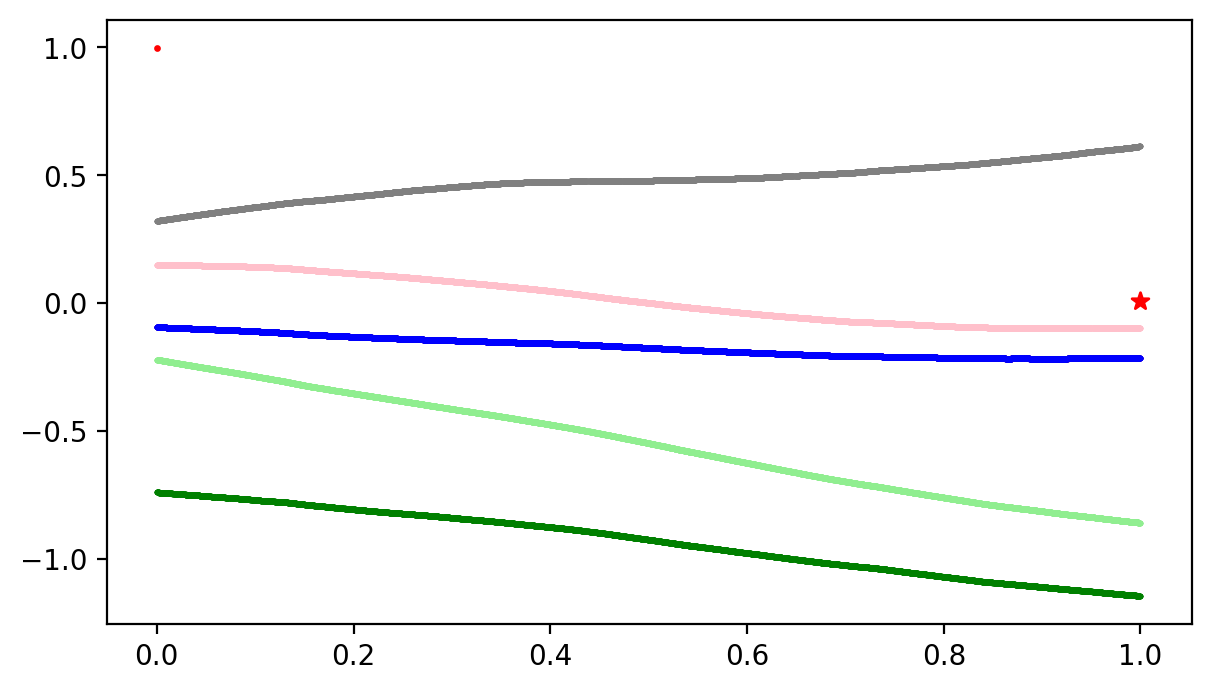

In [76]:
cand = 1000
fn = target_function1
device = torch.device("cuda:3")
num_head=5
model = QRNNModel(device,num_head)

for i in range(1000):
    print('iteration:',i,end='\t')
    x,y = get_data(fn,cand) # (10000),(10000)
    x = x.to(device)
    max_id = model.pred_unce(x).argmax()
    if i == 0:
        train_data_x = x[max_id].view(1,1) 
        train_data_y = fn(x[max_id]).view(1,1)
    else:
        train_data_x = torch.cat((train_data_x,x[max_id].view(1,1))) # (i,1) -> (i+1)
        train_data_y = torch.cat((train_data_y,fn(x[max_id]).view(1,1)))
    model = QRNNModel(device,num_head)
    model.learn(train_data_x,train_data_y)
    
    # plot
    model = QRNNModel(device,num_head)
    clear_output(wait=True)
    plt.figure(figsize=(7,4),dpi=200)
    x, y = get_data(target_function1,10000)
    x = x.to(device)
    y = y.to(device)
    y_hat = model.pred_quantile(x)
    print(y_hat)
    time.sleep(2)
    for i,c in zip(range(num_head),['green','lightgreen','purple','pink','gray','green','lightgreen','purple','pink','gray']):
        plt.scatter(nm(x),nm(y_hat)[:,i],s=1,c=c)
    plt.scatter(nm(x),nm(model.pred_mean(x)),s=1,c='blue')
    unc = nm(model.pred_unce(x))
    # plt.scatter(nm(x),(unc-unc.min())/(unc.max()-unc.min()+1e-7)+0.1,s=1,c='orange')
    # plt.scatter(nm(x),nm(y),s=1,alpha=0.01,c='pink')
    plt.scatter(nm(train_data_x),nm(train_data_y),s = 2,color='red')
    plt.scatter([nm(train_data_x)[-1]],[nm(train_data_y)[-1]],s = 40,color='red',marker='*')
    plt.pause(0.05)

In [18]:
print(num_head)

5


# pdf regression

In [77]:
def get_noisy_data(fn,N):
    x1 = torch.rand(int(N/2))/2
    x2 = torch.rand(int(N/4))/2 + 0.5
    x3 = torch.rand(int(N/4))/2 + 0.5
    y1 = fn(x1) + torch.randn(int(N/2))
    y2 = fn(x2) + torch.randn(int(N/4))-2
    y3 = fn(x3) + torch.randn(int(N/4))+2
    return torch.cat((x1,x2,x3)),torch.cat((y1,y2,y3))

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches

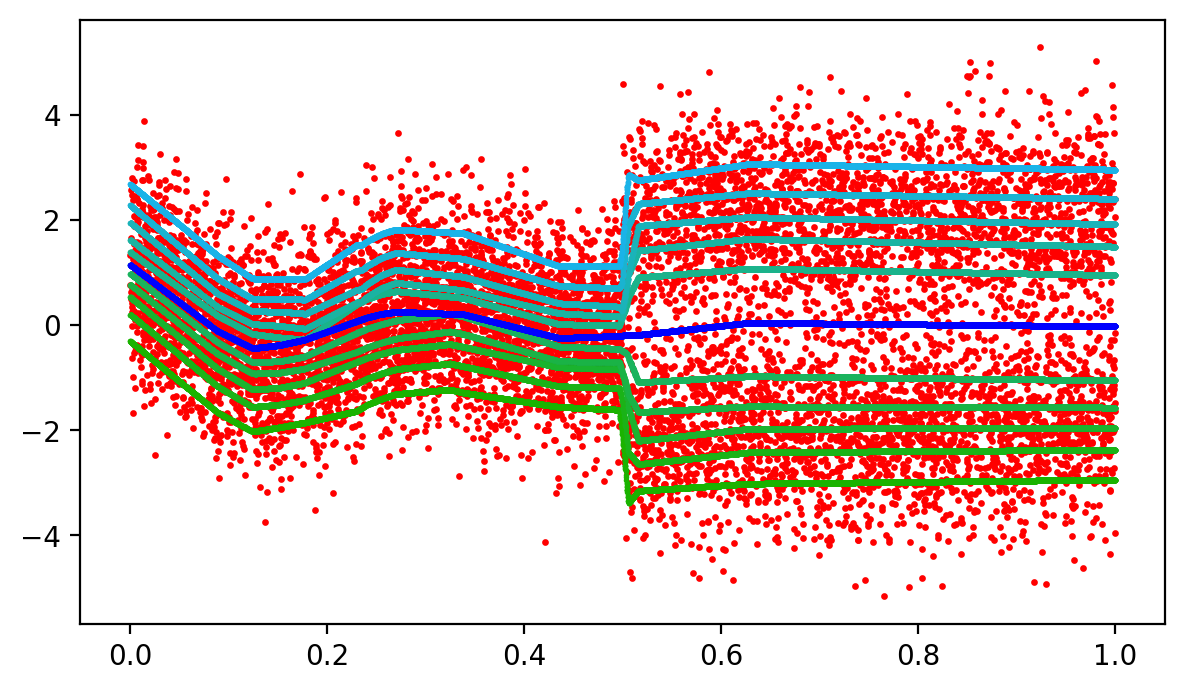

iteration: 409	

In [ ]:
cand = 10000
fn = target_function1
device = torch.device("cuda:3")
num_head=11
model = QRNNModel(device,num_head)
print(model.q_head)

for i in range(1000):
    print('iteration:',i,end='\t')
    x,y = get_data(fn,cand) # (10000),(10000)
    x = x.to(device)
    x,y = get_noisy_data(fn,cand) # (10000),(10000)
    train_data_x = x.unsqueeze(-1).to(device)
    train_data_y = y.unsqueeze(-1).to(device)
    # model = QRNNModel(device,num_head)
    model.learn(train_data_x,train_data_y)
    
    # plot
    clear_output(wait=True)
    plt.figure(figsize=(7,4),dpi=200)
    x, y = get_data(target_function1,10000)
    x = x.to(device)
    y = y.to(device)
    y_hat = model.pred_quantile(x)
    plt.scatter(nm(train_data_x),nm(train_data_y),s = 2,color='red')
    plt.scatter([nm(train_data_x)[-1]],[nm(train_data_y)[-1]],s = 40,color='red',marker='*')
    for i,c in zip(range(num_head),[(0.1, 0.7 , n/num_head) for n in range(num_head)]):
        plt.scatter(nm(x),nm(y_hat)[:,i],s=1,c=c)
    plt.scatter(nm(x),nm(model.pred_mean(x)),s=1,c='blue')
    unc = nm(model.pred_unce(x))
    # plt.scatter(nm(x),(unc-unc.min())/(unc.max()-unc.min()+1e-7)+0.1,s=1,c='orange')
    # plt.scatter(nm(x),nm(y),s=1,alpha=0.01,c='pink')
    plt.pause(0.05)

# ====== Legacy ======

(array([2.1000e+01, 3.6700e+02, 3.3070e+03, 1.4439e+04, 3.0790e+04,
        3.1397e+04, 1.5604e+04, 3.6320e+03, 4.1400e+02, 2.9000e+01]),
 array([-4.4125648 , -3.5355144 , -2.658464  , -1.7814137 , -0.90436333,
        -0.02731299,  0.84973735,  1.7267877 ,  2.603838  ,  3.4808884 ,
         4.357939  ], dtype=float32),
 <a list of 10 Patch objects>)

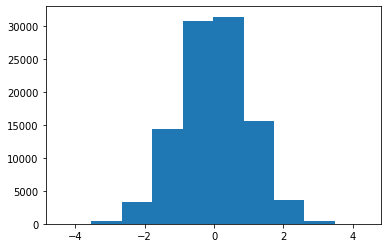

In [40]:
plt.hist(torch.randn(100000))

## Pseudo code (Animaton!!)

In [208]:
from IPython import display
from IPython.display import clear_output

In [68]:
cand = 1000
fn = target_function1
device = torch.device("cuda:1")
num_head=10
th = 0.0001
H = 100
model = Multihead_EnsembleRes(num_head,device,to_next_th=th,H=H)

for i in range(1000):
    print('iteration:',i,end='\t')
    x,y = get_noisy_data(fn,cand) # (10000),(10000)
    train_data_x = x.unsqueeze(-1)
    train_data_y = y.unsqueeze(-1)
    model = Multihead_Ensemble(num_head,device,to_next_th=th,H=H)
    model.learn(train_data_x,train_data_y)
    
    # plot
    clear_output(wait=True)
    plt.figure(figsize=(7,4),dpi=200)
    x, y = get_data(target_function1,10000)
    x = x.to(device)
    y = y.to(device)
    y_hat = model.pred(x)
    for i in range(num_head):
        plt.scatter(nm(x),nm(y_hat)[:,i],s=1,c='lightblue')
    plt.scatter(nm(x),nm(model.pred_mean(x)),s=1,c='blue')
    unc = nm(model.pred_unce(x))
    plt.scatter(nm(x),(unc-unc.min())/(unc.max()-unc.min())+0.1,s=1,c='orange')
    # plt.scatter(nm(x),nm(y),s=1,alpha=0.01,c='pink')
    plt.scatter(nm(train_data_x),nm(train_data_y),s = 2,color='red')
    plt.pause(0.05)

NameError: name 'Multihead_EnsembleRes' is not defined